In [1]:
!pip show keras

Name: Keras
Version: 2.2.4
Summary: Deep Learning for humans
Home-page: https://github.com/keras-team/keras
Author: Francois Chollet
Author-email: francois.chollet@gmail.com
License: MIT
Location: /opt/conda/lib/python3.6/site-packages
Requires: numpy, six, pyyaml, keras-applications, h5py, keras-preprocessing, scipy
Required-by: keras-tqdm, ethnicolr


In [2]:
!pip freeze > requirements.txt

In [3]:
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# keras
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, BatchNormalization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Using TensorFlow backend.


/kaggle/input/sf-dl-movie-genre-classification/test.csv
/kaggle/input/sf-dl-movie-genre-classification/sample-submission.csv
/kaggle/input/sf-dl-movie-genre-classification/train.csv


In [4]:
# seed values
SEED = 42
random.seed = SEED
np.random.seed(seed=SEED)

# SETUP
В setup выносим основные настройки

In [5]:
# MODEL
BATCH_SIZE  = 128
EPOCH       = 10
VAL_SPLIT   = 0.15  #15%

# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 20000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 150

DATA_PATH = '/kaggle/input/sf-dl-movie-genre-classification/'

# Data
#### TRAIN

In [6]:
train_df = pd.read_csv(DATA_PATH+'train.csv',)

In [7]:
train_df.head()

,name,genre,text
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 3 columns):
name     54214 non-null object
genre    54214 non-null object
text     54214 non-null object
dtypes: object(3)
memory usage: 1.2+ MB


Text(0, 0.5, 'Counts')

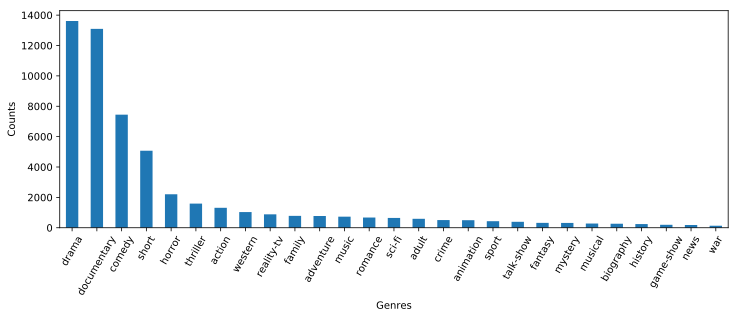

In [9]:
train_df.genre.value_counts().plot(kind='bar',figsize=(12,4),fontsize=10)
plt.xticks(rotation=60)
plt.xlabel("Genres",fontsize=10)
plt.ylabel("Counts",fontsize=10)

### TEST

In [10]:
test_df = pd.read_csv(DATA_PATH+'test.csv')
test_df.head()

,name,text
0,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,Er nu zhai (1955),Before he was known internationally as a mart...


### Target

In [11]:
Y = pd.get_dummies(train_df.genre)
CLASS_NUM = Y.shape[1]
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (54214, 27)


In [12]:
Y.head()

,action,adult,adventure,animation,biography,comedy,crime,documentary,drama,family,...,news,reality-tv,romance,sci-fi,short,sport,talk-show,thriller,war,western
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


# Preprocessing

### Clean Data

In [13]:
# данные у нас и так достаточно чистые

### Tokenize data and convert the text to sequences

Токенизация — это самый первый шаг при обработке текста. Заключается в разбиении (разделении) длинных строк текста в более мелкие: абзацы делим на предложения, предложения на слова. В итоге мы получаем некий словарь, который позволит превратить наш текст в векторное представление для сети.

в Keras есть замечательная утидлита [Tokenizer](https://keras.io/preprocessing/text/) которая позволяет сделать всю предобработку буквально в пару строчек кода! 
Больше примеров в коде можно найти тут:  
https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/

In [14]:
# для построения словаря мы используем весь текст
all_text = train_df.text.append(test_df.text, ignore_index=True)

In [15]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(all_text)

CPU times: user 9.69 s, sys: 80 ms, total: 9.77 s
Wall time: 9.79 s


теперь переведем наш текст в вектор

In [16]:
%%time
sequences = tokenize.texts_to_sequences(train_df.text)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=MAX_SEQUENCE_LENGTH)
print(sequences_matrix.shape)

(54214, 150)
CPU times: user 4.5 s, sys: 48 ms, total: 4.54 s
Wall time: 4.54 s


In [17]:
# вот так теперь выглядит наш текст
print(train_df.text[1])
print(sequences_matrix[1])

 A brother and sister with a past incestuous relationship have a current murderous relationship. He murders the women who reject him and she murders the women who get too close to him.
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     3   194
     2   255     9     3   162 13276   201    41     3   906  4142   201
    11  1493

# Model
Архитектура сети достаточно простая. Попробуйте самостоятельно поиграться с гиперпараметрами сети и составом слоев. 


In [18]:
def RNN():
    inputs = Input(name='inputs',shape=[MAX_SEQUENCE_LENGTH])
    layer = Embedding(MAX_WORDS,50,input_length=MAX_SEQUENCE_LENGTH)(inputs)
    layer = LSTM(100)(layer)
    layer = Dense(256, activation='relu', name='FC1')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(CLASS_NUM, activation='sigmoid', name='out_layer')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [19]:
model = RNN()
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 50)           1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               60400     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               25856     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 27)                6939      
Total params: 1,093,195
Trainable params: 1,093,195
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(sequences_matrix,Y,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCH,
                    validation_split=VAL_SPLIT)

Train on 46081 samples, validate on 8133 samples
Epoch 1/10
46081/46081 [==============================] - 83s 2ms/step - loss: 2.4299 - acc: 0.2500 - val_loss: 2.3387 - val_acc: 0.2524
Epoch 2/10
46081/46081 [==============================] - 81s 2ms/step - loss: 2.1224 - acc: 0.2870 - val_loss: 1.9113 - val_acc: 0.4372
Epoch 3/10
46081/46081 [==============================] - 81s 2ms/step - loss: 1.7601 - acc: 0.4596 - val_loss: 1.8147 - val_acc: 0.4553
Epoch 4/10
46081/46081 [==============================] - 80s 2ms/step - loss: 1.5747 - acc: 0.5003 - val_loss: 1.7986 - val_acc: 0.4873
Epoch 5/10
46081/46081 [==============================] - 80s 2ms/step - loss: 1.4260 - acc: 0.5608 - val_loss: 1.8035 - val_acc: 0.4934
Epoch 6/10
46081/46081 [==============================] - 80s 2ms/step - loss: 1.2517 - acc: 0.6162 - val_loss: 1.8440 - val_acc: 0.5062
Epoch 7/10
46081/46081 [==============================] - 81s 2ms/step - loss: 1.1224 - acc: 0.6553 - val_loss: 1.9878 - val_acc:

In [21]:
model.save('keras_nlp_lstm.h5')

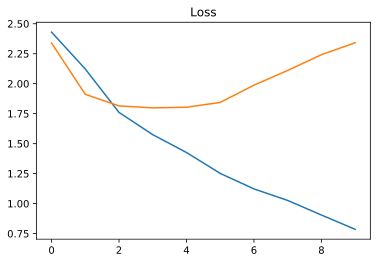

In [22]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.show();

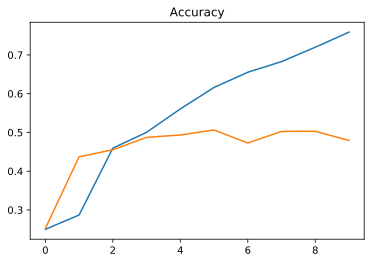

In [23]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.show();

# Submission

In [24]:
test_sequences = tokenize.texts_to_sequences(test_df.text)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=MAX_SEQUENCE_LENGTH)

In [25]:
%%time
predict_proba = model.predict(test_sequences_matrix)

CPU times: user 3min 5s, sys: 23.4 s, total: 3min 29s
Wall time: 2min 11s


In [26]:
# на соревнованиях всегда сохраняйте predict_proba, чтоб потом можно было построить ансамбль решений
predict_proba = pd.DataFrame(predict_proba, columns=Y.columns)
predict_proba.to_csv('predict_proba.csv', index=False)
predict_proba.head()

,action,adult,adventure,animation,biography,comedy,crime,documentary,drama,family,...,news,reality-tv,romance,sci-fi,short,sport,talk-show,thriller,war,western
0,0.202417,0.003238,0.074671,0.032530,0.002532,0.011836,8.209646e-02,0.004044,0.075929,0.020430,...,1.156926e-04,0.001218,7.427037e-04,0.092834,0.055680,4.207790e-04,1.467764e-04,5.337125e-02,0.027336,0.005591
1,0.000270,0.000007,0.000567,0.000058,0.000259,0.001972,3.502965e-04,0.004841,0.434797,0.001372,...,3.039837e-06,0.000044,1.597315e-03,0.000018,0.034385,2.086163e-06,2.563000e-06,3.023148e-04,0.000101,0.000019
2,0.000002,0.000000,0.000066,0.000002,0.001644,0.000013,2.384186e-07,0.891626,0.000945,0.000066,...,2.525151e-04,0.000350,7.748604e-07,0.000006,0.018479,3.919005e-05,9.009242e-05,2.384186e-07,0.000009,0.000000
3,0.000134,0.000002,0.000176,0.000012,0.000045,0.001120,2.286732e-04,0.002202,0.538931,0.000417,...,3.576279e-07,0.000009,6.223321e-04,0.000005,0.028632,1.788139e-07,4.172325e-07,6.092191e-04,0.000014,0.000008
4,0.013197,0.000744,0.007232,0.002421,0.002591,0.022132,2.758214e-02,0.005558,0.644827,0.018159,...,7.194281e-05,0.000602,2.279755e-02,0.001118,0.094080,7.209182e-05,9.053946e-05,3.295162e-02,0.003157,0.001451


In [27]:
predict_genre = Y.columns[np.argmax(predict_proba.values, axis=1)]

In [28]:
submission = pd.DataFrame({'id':range(1, len(predict_genre)+1), 
                           'genre':predict_genre}, 
                          columns=['id', 'genre'])

submission.to_csv('submission.csv', index=False)
submission.head()

,id,genre
0,1,action
1,2,drama
2,3,documentary
3,4,drama
4,5,drama


Готово!

## Что можно сделать, чтоб улучшить результат:
* Подобрать LR, optimizer, loss
* Поиграться с архитектурой
* Подобрать другие переменные (MAX_WORDS, MAX_SEQUENCE_LENGTH, батч и тп)
* Добавить политику обучения
* Добавить в обучение название фильма (для pro: попробуйте это сделать через concatenate слой)
* Попробовать уже предобученные Векторизаторы (GLOVE, W2V и тд)
* Попробовать уже предобученные модели (BERT, TRANFORMER и тд)
* Построить ансамбль из разных архитектур

### Удачи в соревновании!